# Denoising single-cell RNA-seq datasets using deep autoencoders

The purpose of this project is to create a method that uses denoises single-cell RNA-seq datasets using deep autoencoders. 

The pipeline:
1. Feed data into neural network (autoencoder) to get low dimensional representation (done locally in python). This step inputs an M-by-N matrix and outputs a k-by-N matrix (lower dimensional representation).
2. Create a similarity matrix between genes using the clean representations (done on server in python). This step inputs a k-by-N matrix and outputs a N-by-N matrix. 
3. Robust PCA with a Laplacian regularization term (done on server in matlab). This step inputs a M-by-N matrix (original matrix) and outputs a M-by-N low-rank approximation.
4. Cluster on the low-rank matrix (python on server). 

Use MATLAB at this point to perform ADMM, since MATLAB's implementation of SVD is super fast. Perform further processing after obtaining a clean representation of the data. 

In [185]:
# Use scikit-learn to perform clustering

from sklearn import cluster,manifold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
    
# obtain labels via spectral clustering
def jz_spectral(X,k):
    spectral = cluster.SpectralClustering(n_clusters=k)
    spectral.fit(X)
    labels = spectral.labels_
    return labels

# obtain labels via spectral clustering after SVD
def jz_spectral_svd(X,k):
    u,s,v = np.linalg.svd(X, full_matrices=0, compute_uv=1)
    return jz_spectral(u[:,0:(k+1)],k)

# obtain labels via kmeans
def jz_kmeans(X,k,num_iter=50):
    k_means = cluster.KMeans(n_clusters=k,max_iter=num_iter,precompute_distances=True)
    k_means.fit(X)
    labels = k_means.labels_
    return labels

# Plot function with colors corresponding to labels (first two columns of X)
def jz_plot(X,labels,title,s=1):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15,10))
    x = np.arange(len(unique_labels))
    ys = [i+x+(i*x)**2 for i in range(len(unique_labels))]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    i = 0
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        plt.scatter(X[ind,0],X[ind,1],c=colors[i],s=s)
        i += 1
    plt.title(title)
    plt.show()
    
# obtain two major directions from t-SNE
def jz_tSNE(X):
    tsne = manifold.TSNE(n_components=2);
    X_tsne = tsne.fit_transform(X);
    return X_tsne

# obtain two major directions from t-SNE
def jz_PCA(X):
    pca = PCA(n_components=2);
    X_pca = pca.fit_transform(X);
    return X_pca

In [206]:
# Load in processed matrix
import numpy as np

# Full analysis pipeline
def analyze(lab,lamb,k,plotobj=True):
    lab_name = lab.split('_')[0]
    U = np.loadtxt('./ADMM_results/U_'+lab+'_'+lamb+'.txt')
    truth = np.loadtxt('./data/'+lab_name+'/'+lab_name+'_labels.txt')
    # Run kmeans clustering 10 times (to account for randomness of kmeans)
    scores = []
    for i in range(10):
        Ls = jz_kmeans(U,k)
        a,b = max_match_labels(truth,Ls)
        scores.append(a)
    if plotobj:
        plt.plot(np.loadtxt('./ADMM_results/obj_'+lab+'_'+lamb+'.txt'))
        plt.title('Objective for ' + lab + ' ' + ' and lambda = ' + lamb )
        plt.show()
    return scores

# Analyze all lambda
def analyze_all_lambda(lambdas,lab,k,po=True):
    scores_U = []
    for lamb in lambdas:
        print 'ANALYZING ' +lab+ ' FOR LAMBDA = '+lamb+':'
        scores = analyze(lab,lamb,k,po)
        scores_U.append(scores)
    scores_U = np.transpose(np.array(scores_U))
    plot_analysis(lambdas,scores_U)
    return scores_U

# Plot lambda vs accuracy
def plot_analysis(lambdas,x):
    X = pickle.load(file('X_kmeans_scores.dat','rb'))
    X = np.transpose(np.tile(X,[len(lambdas),1]))
    ax = plt.figure(figsize=(9,5))
    ax = plt.subplot(111)
    lambdas = [float(i) for i in lambdas]
    plt.errorbar(lambdas,np.mean(x,axis=0),color='b',
                 yerr=np.std(x,axis=0)/np.sqrt(np.shape(x)[0]),linewidth=3.0,label='U')
    plt.errorbar(lambdas,np.mean(X,axis=0),color='r',
                 yerr=np.std(X,axis=0)/np.sqrt(np.shape(X)[0]),linewidth=3.0,label='X')
    plt.xlim(min(lambdas)/2,max(lambdas)*2)
    ax.set_xscale('log')
    plt.grid()
    plt.xlabel('lambda')
    plt.ylabel('accuracy (maxed cluster matching)')
    plt.legend()
    plt.show()
    
import itertools

# This function compares the max matching between two labels
def max_match_labels(L1,L2):
    uniqL1 = np.unique(L1)
    uniqL2 = np.unique(L2)
    max_score = 0
    perms = list(itertools.permutations(uniqL1))
    for perm in perms:
        score = 0
        for i in range(len(uniqL1)):
            score += np.sum((L1 == perm[i])*(L2 == uniqL2[i]))
        if score > max_score: 
            max_score = score
            ideal_perm = perm
    return float(max_score)/len(L1),ideal_perm

# Full analysis given the file name of a data matrix
def analyze_data_matrix(flname,fllabels,k):
    X = np.loadtxt(flname)
    L = np.loadtxt(fllabels,dtype=str)
#     Ls = jz_spectral_svd(X,k)
    Ls = jz_kmeans(X,k)
    return max_match_labels(L,Ls)
    

In [80]:
# kmeans 2 layers
import os
d2 = {}

for flname in sorted(os.listdir('./Buettner_2layer_keras/')):
    a,b = analyze_data_matrix('./Buettner_2layer_keras/'+flname,'./data/Buettner/Buettner_labels.txt',k=3)
    d2[flname] = a
    print str(a)+' '+flname

0.675824175824 X_Buettner_keras_linear_10hidden_0.2dropout_recon.txt
0.708791208791 X_Buettner_keras_linear_20hidden_0.2dropout_recon.txt
0.703296703297 X_Buettner_keras_linear_3hidden_0.2dropout_recon.txt
0.642857142857 X_Buettner_keras_linear_50hidden_0.2dropout_recon.txt
0.714285714286 X_Buettner_keras_linear_5hidden_0.2dropout_recon.txt
0.675824175824 X_Buettner_keras_linear_7hidden_0.2dropout_recon.txt
0.71978021978 X_Buettner_keras_linear_90hidden_0.2dropout_recon.txt
0.593406593407 X_Buettner_keras_relu_10hidden_0.2dropout_recon.txt
0.576923076923 X_Buettner_keras_relu_20hidden_0.2dropout_recon.txt
0.56043956044 X_Buettner_keras_relu_3hidden_0.2dropout_recon.txt
0.554945054945 X_Buettner_keras_relu_50hidden_0.2dropout_recon.txt
0.56043956044 X_Buettner_keras_relu_5hidden_0.2dropout_recon.txt
0.527472527473 X_Buettner_keras_relu_7hidden_0.2dropout_recon.txt
0.582417582418 X_Buettner_keras_relu_90hidden_0.2dropout_recon.txt
0.571428571429 X_Buettner_keras_sigmoid_10hidden_0.2dropo

In [81]:
# kmeans 3 layers
import os
d3 = {}

for flname in sorted(os.listdir('./Buettner_3layer_keras/')):
    a,b = analyze_data_matrix('./Buettner_3layer_keras/'+flname,'./data/Buettner/Buettner_labels.txt',k=3)
    d3[flname] = a
    print str(a)+' '+flname

0.648351648352 X_Buettner_keras_linear_50hidden1_10hidden2_recon.txt
0.741758241758 X_Buettner_keras_linear_50hidden1_20hidden2_recon.txt
0.692307692308 X_Buettner_keras_linear_50hidden1_3hidden2_recon.txt
0.708791208791 X_Buettner_keras_linear_50hidden1_5hidden2_recon.txt
0.774725274725 X_Buettner_keras_linear_90hidden1_10hidden2_recon.txt
0.664835164835 X_Buettner_keras_linear_90hidden1_20hidden2_recon.txt
0.736263736264 X_Buettner_keras_linear_90hidden1_3hidden2_recon.txt
0.675824175824 X_Buettner_keras_linear_90hidden1_5hidden2_recon.txt
0.587912087912 X_Buettner_keras_relu_50hidden1_10hidden2_recon.txt
0.593406593407 X_Buettner_keras_relu_50hidden1_20hidden2_recon.txt
0.587912087912 X_Buettner_keras_relu_50hidden1_3hidden2_recon.txt
0.587912087912 X_Buettner_keras_relu_50hidden1_5hidden2_recon.txt
0.571428571429 X_Buettner_keras_relu_90hidden1_10hidden2_recon.txt
0.60989010989 X_Buettner_keras_relu_90hidden1_20hidden2_recon.txt
0.598901098901 X_Buettner_keras_relu_90hidden1_3hidde

In [82]:
# kmeans 4 layers
import os
d4 = {}

for flname in sorted(os.listdir('./Buettner_4layer_keras/')):
    a,b = analyze_data_matrix('./Buettner_4layer_keras/'+flname,'./data/Buettner/Buettner_labels.txt',k=3)
    d4[flname] = a
    print str(a)+' '+flname

0.664835164835 X_Buettner_keras_linear_120hidden1_10hidden2_2recon.txt
0.681318681319 X_Buettner_keras_linear_120hidden1_10hidden2_3recon.txt
0.675824175824 X_Buettner_keras_linear_120hidden1_10hidden2_5recon.txt
0.686813186813 X_Buettner_keras_linear_120hidden1_20hidden2_2recon.txt
0.659340659341 X_Buettner_keras_linear_120hidden1_20hidden2_3recon.txt
0.741758241758 X_Buettner_keras_linear_120hidden1_20hidden2_5recon.txt
0.692307692308 X_Buettner_keras_linear_120hidden1_40hidden2_2recon.txt
0.708791208791 X_Buettner_keras_linear_120hidden1_40hidden2_3recon.txt
0.725274725275 X_Buettner_keras_linear_120hidden1_40hidden2_5recon.txt
0.664835164835 X_Buettner_keras_linear_50hidden1_10hidden2_2recon.txt
0.736263736264 X_Buettner_keras_linear_50hidden1_10hidden2_3recon.txt
0.736263736264 X_Buettner_keras_linear_50hidden1_10hidden2_5recon.txt
0.659340659341 X_Buettner_keras_linear_50hidden1_20hidden2_2recon.txt
0.697802197802 X_Buettner_keras_linear_50hidden1_20hidden2_3recon.txt
0.730769230

In [161]:
# kmeans 5 layers
import os
d5 = {}

for flname in sorted(os.listdir('./Buettner_5layer_keras/')):
    a,b = analyze_data_matrix('./Buettner_5layer_keras/'+flname,'./data/Buettner/Buettner_labels.txt',k=3)
    d5[flname] = a
    print str(a)+' '+flname

0.703296703297 X_Buettner_keras_linear_100hidden1_40hidden2_10hidden3_2recon.txt
0.747252747253 X_Buettner_keras_linear_100hidden1_40hidden2_10hidden3_5recon.txt
0.675824175824 X_Buettner_keras_linear_100hidden1_40hidden2_20hidden3_2recon.txt
0.714285714286 X_Buettner_keras_linear_100hidden1_40hidden2_20hidden3_5recon.txt
0.659340659341 X_Buettner_keras_linear_100hidden1_40hidden2_30hidden3_2recon.txt
0.675824175824 X_Buettner_keras_linear_100hidden1_40hidden2_30hidden3_5recon.txt
0.692307692308 X_Buettner_keras_linear_100hidden1_75hidden2_10hidden3_2recon.txt
0.730769230769 X_Buettner_keras_linear_100hidden1_75hidden2_10hidden3_5recon.txt
0.659340659341 X_Buettner_keras_linear_100hidden1_75hidden2_20hidden3_2recon.txt
0.648351648352 X_Buettner_keras_linear_100hidden1_75hidden2_20hidden3_5recon.txt
0.681318681319 X_Buettner_keras_linear_100hidden1_75hidden2_30hidden3_2recon.txt
0.714285714286 X_Buettner_keras_linear_100hidden1_75hidden2_30hidden3_5recon.txt
0.692307692308 X_Buettner_ke

In [209]:
# kmeans 5 layers. multiple iterations of Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5
import os
d_rep = {}

for flname in sorted(os.listdir('./Buettner_5layer_keras_rep/')):
    a,b = analyze_data_matrix('./Buettner_5layer_keras_rep/'+flname,'./data/Buettner/Buettner_labels.txt',k=3)
    d_rep[flname] = a
    print str(a)+' '+flname

0.807692307692 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_0_recon.txt
0.642857142857 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_10_recon.txt
0.653846153846 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_11_recon.txt
0.675824175824 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_12_recon.txt
0.604395604396 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_13_recon.txt
0.675824175824 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_14_recon.txt
0.67032967033 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_15_recon.txt
0.703296703297 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_16_recon.txt
0.576923076923 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_17_recon.txt
0.587912087912 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_18_recon.txt
0.675824175824 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_19_recon.txt
0.714285714286 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_1_recon.txt
0.86813

ANALYZING Buettner_PCA FOR LAMBDA = 1e-05:
ANALYZING Buettner_PCA FOR LAMBDA = 0.0001:
ANALYZING Buettner_PCA FOR LAMBDA = 0.001:
ANALYZING Buettner_PCA FOR LAMBDA = 0.01:
ANALYZING Buettner_PCA FOR LAMBDA = 0.1:
ANALYZING Buettner_PCA FOR LAMBDA = 1:
ANALYZING Buettner_PCA FOR LAMBDA = 10:
ANALYZING Buettner_PCA FOR LAMBDA = 100:


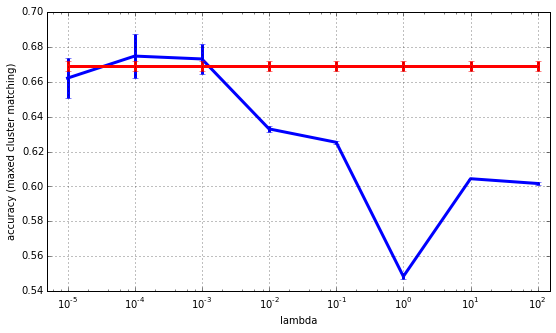

In [145]:
sU = analyze_all_lambda(['1e-05','0.0001','0.001','0.01','0.1','1','10','100'],
                        'Buettner_PCA',k=3,po=False)

ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 1e-05:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 0.0001:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 0.001:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 0.01:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 0.1:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 1:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 10:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 50:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 100:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 500:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 1000:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 10000:
ANALYZING Buettner_keras_linear_90hidden1_20hidden2_recon FOR LAMBDA = 100000:
AN

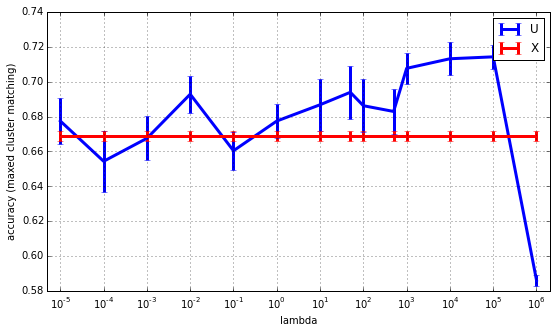

In [156]:
sU = analyze_all_lambda(['1e-05','0.0001','0.001','0.01','0.1','1','10','50','100','500','1000','10000','100000','1000000'],
                        'Buettner_keras_linear_90hidden1_20hidden2_recon',k=3,po=False)

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 1e-05:


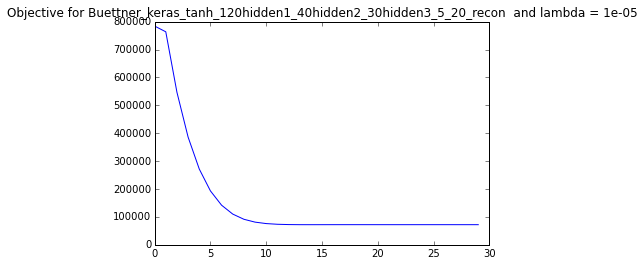

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 0.0001:


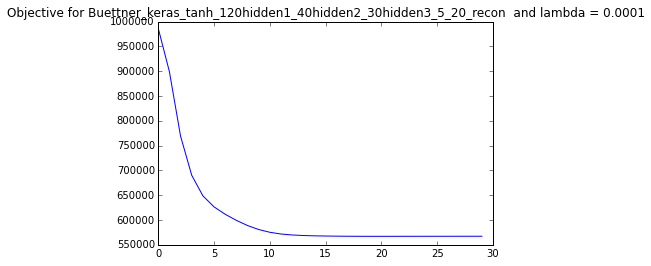

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 0.001:


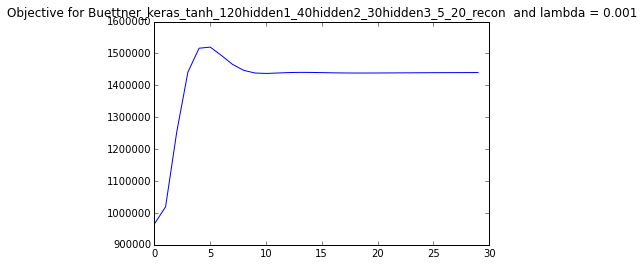

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 0.01:


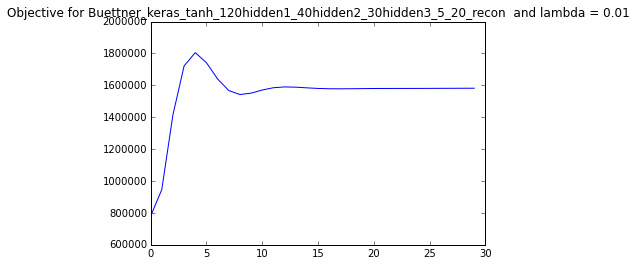

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 0.1:


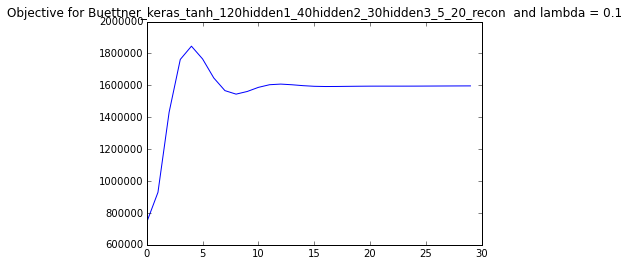

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 1:


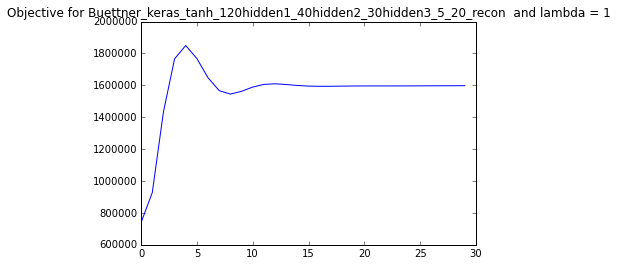

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 10:


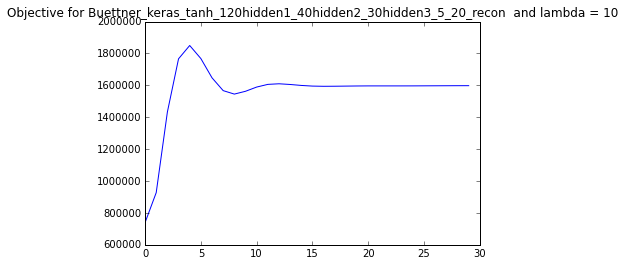

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 50:


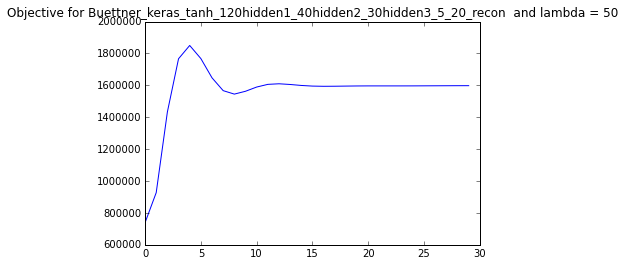

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 100:


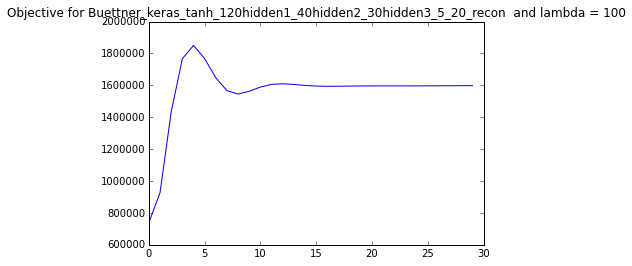

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 500:


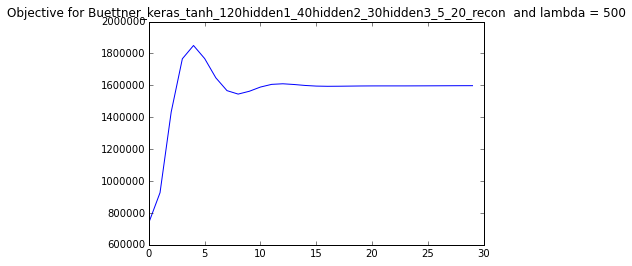

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 1000:


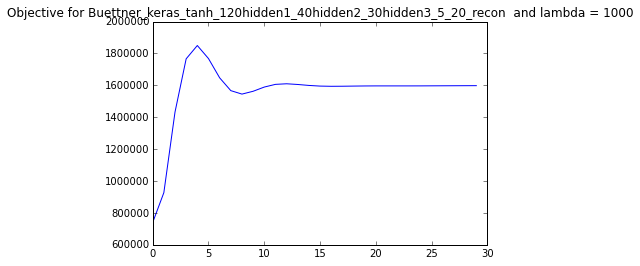

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 10000:


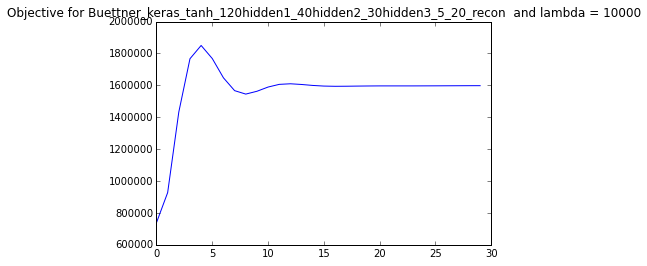

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 100000:


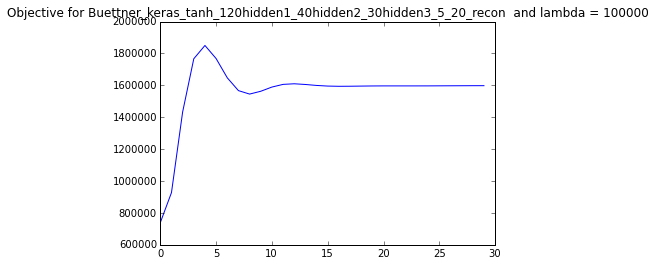

ANALYZING Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon FOR LAMBDA = 1000000:


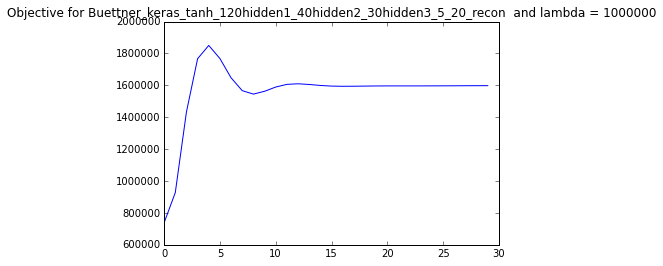

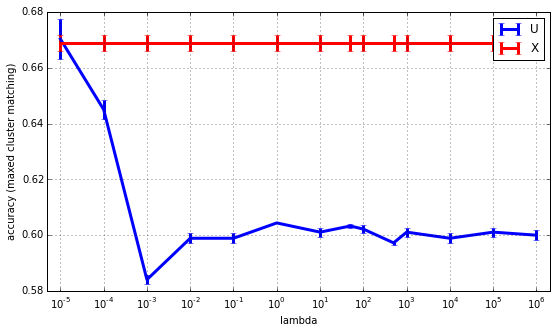

In [216]:
sU = analyze_all_lambda(['1e-05','0.0001','0.001','0.01','0.1','1','10','50','100','500','1000','10000','100000','1000000'],
                        'Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon',k=3,po=True)

In [195]:
def monte_carlo_kmeans(flname,num_iter=200):
    X = np.loadtxt(flname)
    X_scores = []
    for i in range(num_iter):
        Ls = jz_kmeans(X,k=3)
        a,b = max_match_labels(Lt,Ls)
        X_scores.append(a)
    plt.figure(figsize=(8,5))
    plt.hist(X_scores)
    plt.title(flname)
    return X_scores

def generate_visuals(flname,num_iter=200):
    U = np.loadtxt(flname)
    Lt = np.loadtxt('./data/Buettner/Buettner_labels.txt')
    Lu = jz_kmeans(U,3)
    U_PCA = jz_PCA(U)
    jz_plot(U_PCA,Lu,'U_PCA, kmeans',150)
    jz_plot(U_PCA,Lt,'U_PCA, truth',150)
    X_scores = monte_carlo_kmeans(flname,num_iter=200)

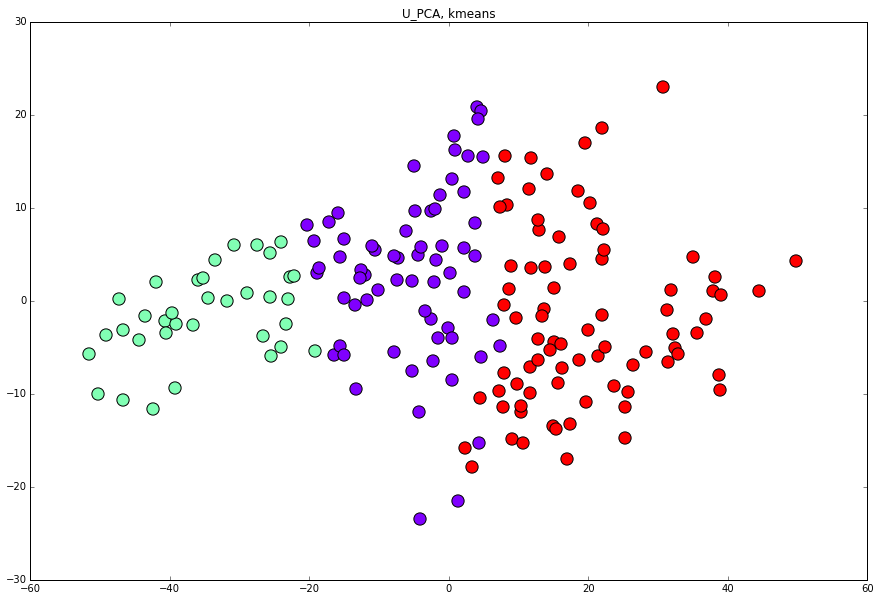

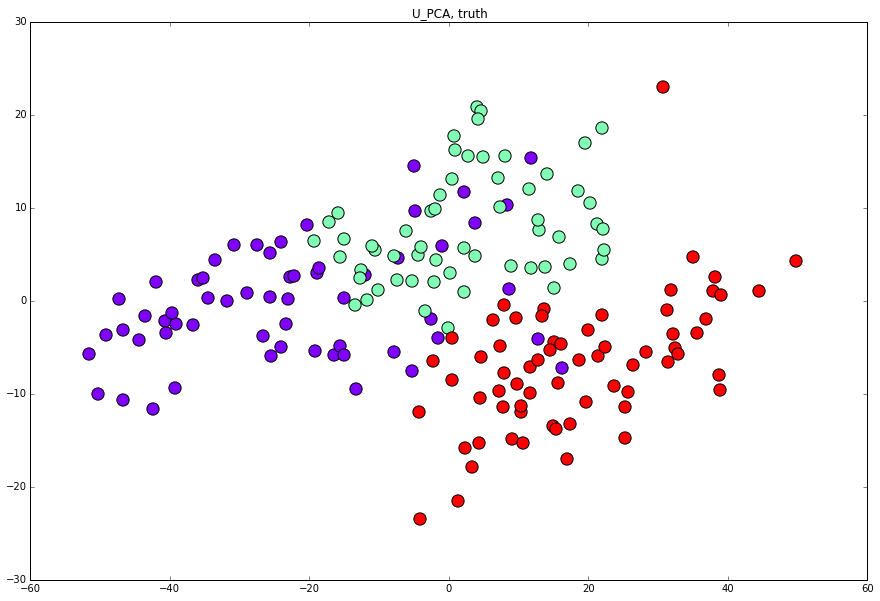

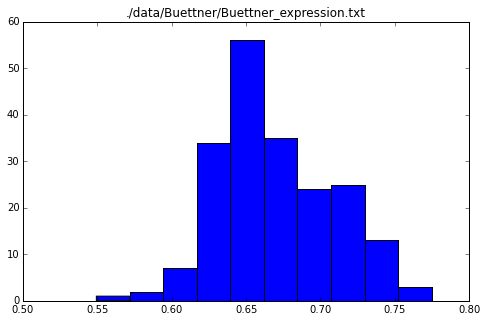

In [196]:
generate_visuals('./data/Buettner/Buettner_expression.txt',num_iter=200)

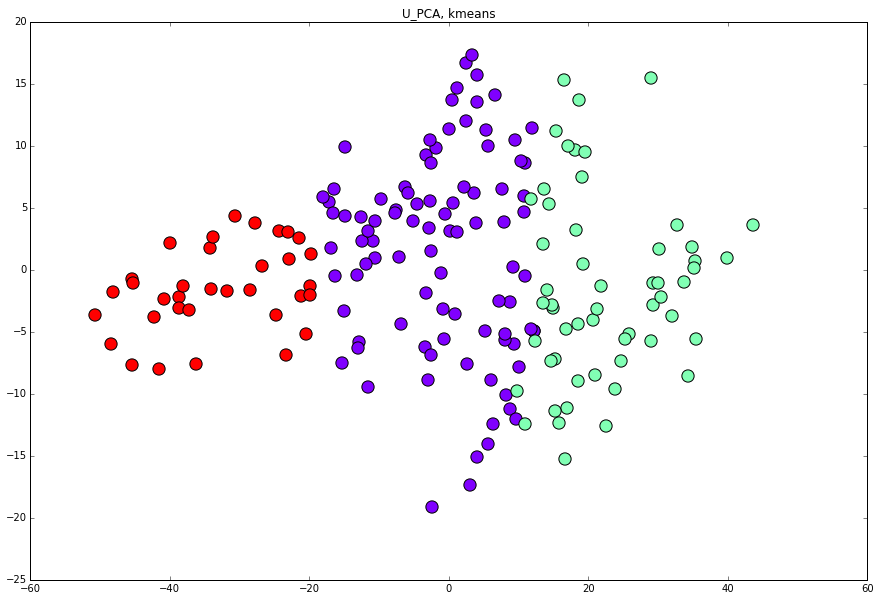

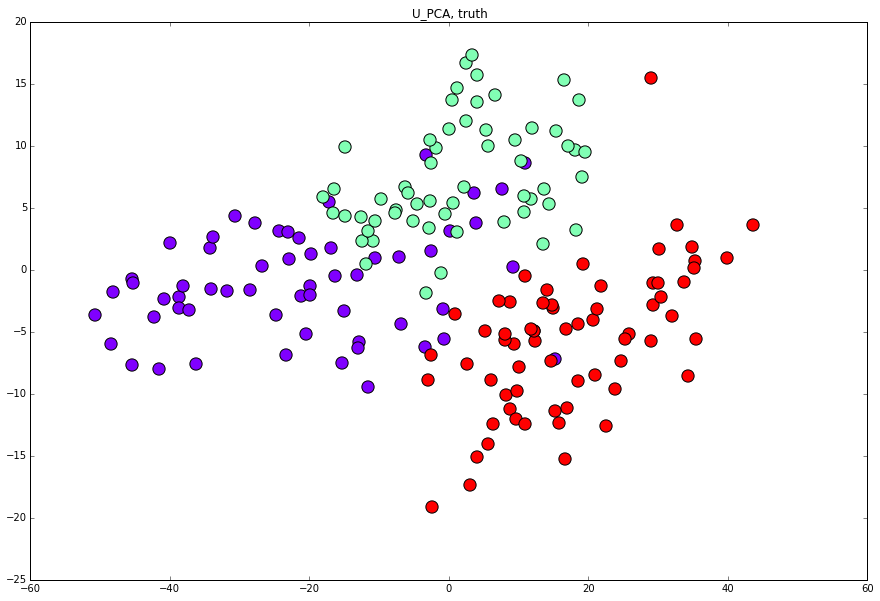

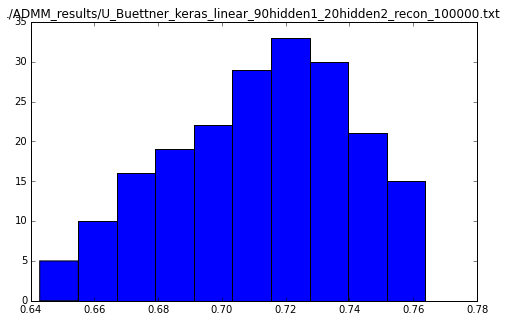

In [204]:
generate_visuals('./ADMM_results/U_Buettner_keras_linear_90hidden1_20hidden2_recon_100000.txt',num_iter=200)

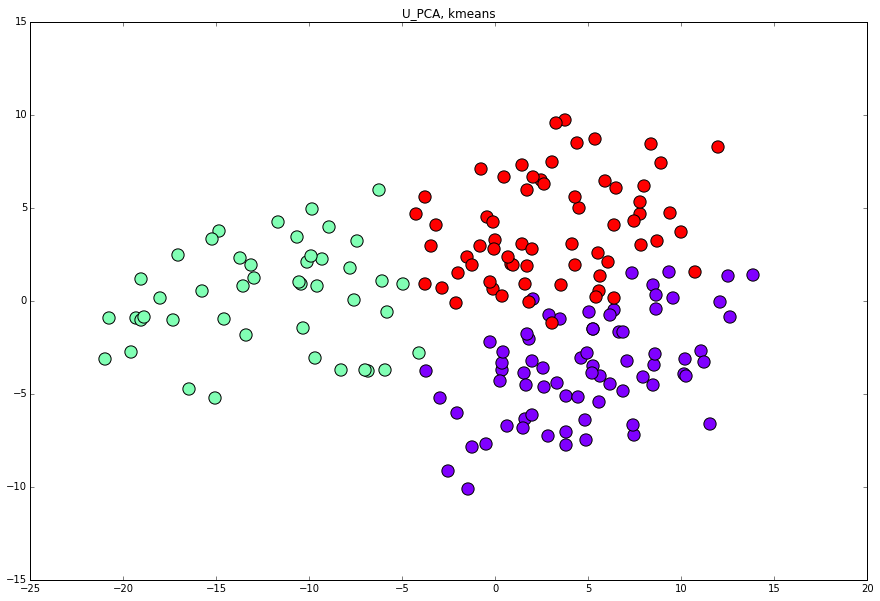

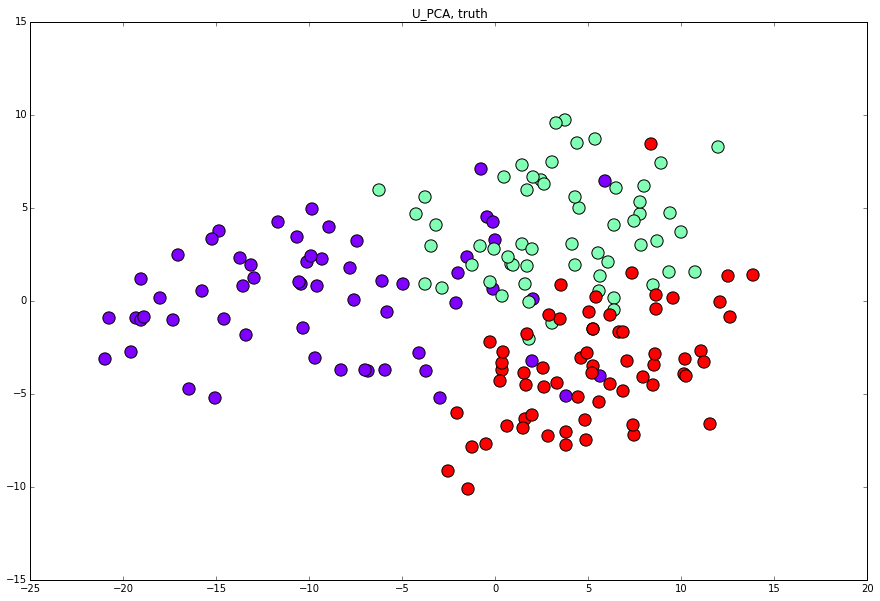

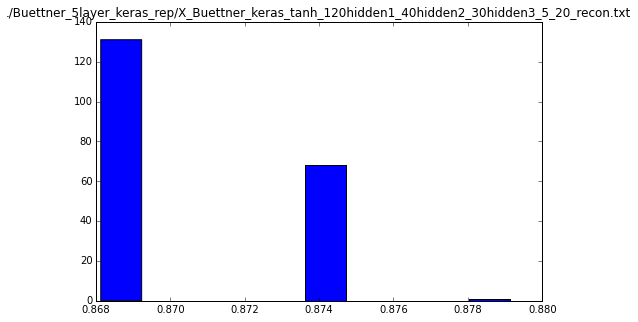

In [210]:
# 0.653846153846 X_Buettner_keras_tanh_100hidden1_40hidden2_10hidden3_5recon.txt
# 0.598901098901 X_Buettner_keras_tanh_100hidden1_40hidden2_20hidden3_5recon.txt
# 0.82967032967 X_Buettner_keras_tanh_100hidden1_40hidden2_30hidden3_5recon.txt
# 0.571428571429 X_Buettner_keras_tanh_100hidden1_80hidden2_10hidden3_5recon.txt
# 0.708791208791 X_Buettner_keras_tanh_100hidden1_80hidden2_20hidden3_5recon.txt
# 0.67032967033 X_Buettner_keras_tanh_100hidden1_80hidden2_30hidden3_5recon.txt
# 0.664835164835 X_Buettner_keras_tanh_120hidden1_40hidden2_10hidden3_5recon.txt
# 0.835164835165 X_Buettner_keras_tanh_120hidden1_40hidden2_20hidden3_5recon.txt
# 0.642857142857 X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5recon.txt
# 0.659340659341 X_Buettner_keras_tanh_120hidden1_80hidden2_10hidden3_5recon.txt
# 0.604395604396 X_Buettner_keras_tanh_120hidden1_80hidden2_20hidden3_5recon.txt
# 0.840659340659 X_Buettner_keras_tanh_120hidden1_80hidden2_30hidden3_5recon.txt

generate_visuals('./Buettner_5layer_keras_rep/X_Buettner_keras_tanh_120hidden1_40hidden2_30hidden3_5_20_recon.txt',num_iter=200)